#!conda install -y cudatoolkit
#!pip install bitsandbytes
!pip install transformers==4.33.2
!pip install datasets
!pip install evaluate
!pip install peft
!pip install accelerate -U
!pip install transformers[torch]
!pip install -r requirements.txt

In [2]:
%pip install -q -U torch==2.0.1 bitsandbytes==0.40.2
%pip install -q -U transformers==4.31.0 peft==0.4.0 accelerate==0.21.0
%pip install -q -U datasets py7zr einops tensorboardX
!pip install evaluate
# Add installed cuda runtime to path for bitsandbytes
import os
import nvidia

cuda_install_dir = '/'.join(nvidia.__file__.split('/')[:-1]) + '/cuda_runtime/lib/'
os.environ['LD_LIBRARY_PATH'] =  cuda_install_dir


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.3.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any

In [3]:
from collections import defaultdict
import copy
import json
import os
import sys
#sys.path.append("/home/sagemaker-user/bitsandbytes")
#os.environ['LD_LIBRARY_PATH'] = '/opt/conda/lib/'
from os.path import exists, join, isdir
from dataclasses import dataclass, field
import sys
from typing import Optional, Dict, Sequence
import numpy as np
from tqdm import tqdm
import logging
#import bitsandbytes as bnb
import pandas as pd

import torch
torch.cuda.init()
print(torch.cuda.is_available())
import os
#os.environ['TRANSFORMERS_CACHE'] = '/project/SDS/research/christ_research/Llama 2/llama2-7b/cache'
import transformers
from torch.nn.utils.rnn import pad_sequence
import argparse
# from transformers import (
#     AutoTokenizer,
#     AutoModelForCausalLM,
#     set_seed,
#     Seq2SeqTrainer,
# #    BitsAndBytesConfig,
#     LlamaTokenizer

# )
from datasets import load_dataset, Dataset
import evaluate

# from peft import (
#     prepare_model_for_kbit_training,
#     LoraConfig,
#     get_peft_model,
#     PeftModel,
#     TaskType
# )
#from peft.tuners.lora import LoraLayer
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
#from dotenv import load_dotenv
import os
torch.backends.cuda.matmul.allow_tf32 = True

# Load the environmental variables from the .env file
#load_dotenv()

#token = os.getenv('text_classifier_token')

#from huggingface_hub import login
#login(token = token)

from datasets import load_dataset, DatasetDict

True


In [4]:
import random

In [5]:
df = pd.read_csv('data/appropriateness.csv')
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/appropriateness.csv')
df

,label,text
0,1,Question: A candy store has 45000 pieces of ca...
1,0,Question: The 12:05 p.m. train from New York t...
2,0,Question: Taylor Swift is on a 2-year contract...
3,1,Question: The Beverly Hills Bakery baked 200 l...
4,0,Question: There are 4 Ninja Turtles. 3 of them...
...,...,...
2535,1,Question: The volleyball team has 12 players. ...
2536,1,Question: Captain America is a superhero. He c...
2537,0,Question: 11111 is a 5-digit number. 22222 is ...
2538,1,Question: The T-Rex is 30 feet long. The Veloc...


In [167]:
df = pd.read_csv('data/appropriateness_test.csv')
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/appropriateness_test.csv')
df

,label,text
0,1,Question: A candy store has 45000 pieces of ca...
1,0,Question: The 12:05 p.m. train from New York t...
2,0,Question: Taylor Swift is on a 2-year contract...
3,1,Question: The Beverly Hills Bakery baked 200 l...
4,0,Question: There are 4 Ninja Turtles. 3 of them...
...,...,...
2267,1,Question: The Cincinnati Bengals have 375 rush...
2268,1,Question: There are 150 different kinds of Pok...
2269,1,Question: A bakery is baking 1000 cookies. 400...
2270,1,Question: A 25-meter pool is 2.5 times as long...


In [45]:
df = pd.read_csv('data/appropriateness.csv')
df['label'] = df['label'].astype('int')
pos = df[df['label']==1]
neg = df[df['label']==0]
neg_len = len(neg)
pos = pos.sample(n = neg_len, replace = False)
df2 = pd.concat([pos, neg])
df2 = df2.sample(frac=1)
df2.reset_index(drop=True, inplace=True)
df2 = df2.drop('Unnamed: 0', axis =1)
df2 = df2[df2['text'].notnull()]
df2.to_csv('data/appropriateness_balanced.csv')
df2

,label,text
0,0,Question: Taylor Swift has 1000s of fans. 1000...
1,1,Question: Barbie has 125 dollars. She has to p...
2,1,"Question: In the first Harry Potter book, Harr..."
3,0,Question: 12345 is a 5-digit number. How many ...
4,1,Question: Serena Williams is the 12th best-pai...
...,...,...
1595,1,Question: A family has 21 dogs. 8 of the dogs ...
1596,0,"Question: In a soccer game, the home team scor..."
1597,0,Question: Patrick Mahomes is the quarterback f...
1598,1,Question: Taylor Swift has 100 cats. 20 of the...


In [46]:
# Load the dataset
#dataset = load_dataset('csv', data_files="data/appropriateness_balanced.csv")
dataset = load_dataset('csv', data_files="data/appropriateness.csv")
#dataset= load_dataset('csv', data_files="data/appropriateness_test.csv")

# Get the total number of examples in the dataset
# total_examples = len(dataset['train'])

# # Calculate the sizes of the training, test, and validation sets
# train_size = int(0.8 * total_examples)
# test_size = int(0.1 * total_examples)
# valid_size = total_examples - train_size - test_size

# # Manually split the dataset into training, test, and validation sets
# train_dataset = dataset['train'].shuffle(seed=42).select(range(train_size))
# test_dataset = dataset['train'].shuffle(seed=42).select(range(train_size, train_size + test_size))
# valid_dataset = dataset['train'].shuffle(seed=42).select(range(train_size + test_size, total_examples))

dataset_train_valid_test = dataset['train'].train_test_split(test_size = .2, seed = 42)
dataset_valid_test = dataset_train_valid_test['test'].train_test_split(test_size = .5, seed = 42)
# Create a DatasetDict to hold the splits
train_test_valid_dataset = DatasetDict({
    'train': dataset_train_valid_test['train'],
    'test': dataset_valid_test['train'],
    'valid': dataset_valid_test['test']
})

In [47]:
train_test_valid_dataset['valid'][2]

{'Unnamed: 0': 771,
 'label': 1,
 'text': 'Question: There are 350 Pokémon in the Kanto region. There are 100 more Pokémon in the Johto region than in the Kanto region. The Hoenn region has 200 more Pokémon than the Johto region. How many Pokémon are there in the Kanto, Johto, and Hoenn regions combined?\nSolution:\ndef solution():\n    #There are 350 Pokémon in the Kanto region\n    pokemon_kanto = 350\n    #There are 100 more Pokémon in the Johto region than in the Kanto region\n    pokemon_johto = pokemon_kanto + 100\n    #The Hoenn region has 200 more Pokémon than the Johto region\n    pokemon_hoenn = pokemon_johto + 200\n    #The answer is\n    result = pokemon_kanto + pokemon_johto + pokemon_hoenn\n    return result\nAnswer: 1450'}

In [48]:
#Set up tokenizer
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_auth_token=True)
# tokenizer.add_special_tokens({"pad_token":"[PAD]"})

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer.add_special_tokens({"pad_token":"[PAD]"})

#Preprocess and collate data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_test_valid_dataset = train_test_valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

In [49]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Prepare evaluation function
import evaluate
accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# roc_auc = evaluate.load("roc_auc")

# import numpy as np
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return roc_auc.compute(prediction_scores=predictions, references=labels)

#Training
id2label = {0: "NOT APPROPRIATE", 1: "APPROPRIATE"}
label2id = {"NOT APPROPRIATE": 0, "APPROPRIATE": 1}

In [50]:
#Import model
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained(
#     "meta-llama/Llama-2-7b-hf", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#       device_map = 'auto',
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

# model = AutoModelForSequenceClassification.from_pretrained(
#     "bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
#NEWLY ADDED
# model.gradient_checkpointing_enable()
# model = prepare_model_for_kbit_training(model)

# peft_config = LoraConfig(
#     task_type=TaskType.SEQ_CLS,
#     r=16,
#     lora_alpha=32,
#     lora_dropout=0.1,
# )      

# model = get_peft_model(model, peft_config)

#END NEWLY ADDED
# training_args = TrainingArguments(
#     output_dir="text_classifier_llama",
#     learning_rate=2e-5,
#     per_device_train_batch_size=1,
#   # auto_find_batch_size = True,
#     num_train_epochs=8,
#     weight_decay=0.01,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True, 
#     bf16=True)

import torch.nn.functional as F

class BertTrainer(Trainer):
    def __init__(self, penalty_factor=2.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.penalty_factor = penalty_factor

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")  # Assuming labels are passed in the inputs
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply softmax to convert logits to probabilities
        probabilities = F.softmax(logits, dim=1)

        # Assuming binary classification, so consider only the positive class (index 1)
        positive_class_probabilities = probabilities[:, 1]

        # Custom loss calculation
        loss = F.binary_cross_entropy(positive_class_probabilities, labels.float())

        # Penalize false positives more heavily based on the defined penalty factor
        false_positive_mask = (positive_class_probabilities > 0.5) & (labels == 0)
        loss += torch.sum(false_positive_mask.float()) * self.penalty_factor

        if return_outputs:
            return loss, outputs
        return loss


training_args = TrainingArguments(
    output_dir="appropriateness_classifier",
    learning_rate=.0001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True)

trainer = BertTrainer(penalty_factor = 3,
    model=model,
    args=training_args,
    train_dataset=tokenized_train_test_valid_dataset["train"],
    eval_dataset=tokenized_train_test_valid_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#trainer.train(resume_from_checkpoint=True)
trainer.train()
print(tokenized_train_test_valid_dataset["test"])
test_input_data = tokenized_train_test_valid_dataset["test"]["input_ids"]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,9.605584,0.775591
2,No log,10.059577,0.748031
3,No log,10.859417,0.736220
4,1.335600,11.348425,0.767717
5,1.335600,11.441024,0.744094
6,1.335600,10.021024,0.751969
7,1.335600,9.762471,0.759843
8,0.802600,9.298748,0.755906


Dataset({
    features: ['Unnamed: 0', 'label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 254
})


In [61]:
# predictions = trainer.predict(test_dataset=test_input_data)
# print(predictions)
trainer.evaluate(eval_dataset = tokenized_train_test_valid_dataset["test"])

{'eval_loss': 13.411481857299805,
 'eval_accuracy': 0.7086614173228346,
 'eval_runtime': 1.5003,
 'eval_samples_per_second': 169.301,
 'eval_steps_per_second': 10.665,
 'epoch': 8.0}

In [62]:
predictions = trainer.predict(test_dataset = tokenized_train_test_valid_dataset["test"])
predictions

PredictionOutput(predictions=array([[-3.481024  ,  2.1024683 ],
       [-3.296541  ,  2.0033636 ],
       [-3.4807255 ,  2.101745  ],
       [-1.82852   ,  1.6009136 ],
       [-3.3376293 ,  2.0244064 ],
       [-2.9998333 ,  1.8323044 ],
       [-3.4136558 ,  2.0663888 ],
       [-3.4445567 ,  2.0824883 ],
       [-2.4331467 ,  1.4758114 ],
       [-3.3149827 ,  2.0137496 ],
       [-0.0518111 , -0.06395761],
       [-3.4806206 ,  2.102062  ],
       [ 2.7865038 , -3.3175108 ],
       [ 2.7082427 , -3.221099  ],
       [-3.4534316 ,  2.0863004 ],
       [-3.3189692 ,  2.0143037 ],
       [-2.971042  ,  1.813267  ],
       [-1.816918  ,  1.0733565 ],
       [-3.3404062 ,  2.027843  ],
       [-3.3014572 ,  2.0051856 ],
       [-3.167358  ,  1.9298319 ],
       [ 2.6033545 , -3.097751  ],
       [-3.2706223 ,  1.9881661 ],
       [-3.3699765 ,  2.0434368 ],
       [-3.4361863 ,  2.0786245 ],
       [-3.4692712 ,  2.0954952 ],
       [-3.4449596 ,  2.0818467 ],
       [-3.349778  ,  2.03

In [63]:
import torch
import torch.nn.functional as F
def compute_fp_tp(predictions):
    fp = 0
    tn = 0
    tp = 0
    fn = 0
    y_scores = predictions[0]
    y_scores = torch.tensor(y_scores)
    y_scores = F.softmax(y_scores, dim=1).numpy()
    y_scores= np.argmax(y_scores, axis=1)
    y_true = predictions[1]
    for i in range(0, len(y_scores)):
        if y_scores[i] == 1 and y_true[i] == 0:
            fp+=1
        if y_scores[i] == 0 and y_true[i] == 0:
            tn+=1
        if y_scores[i] == 1 and y_true[i] == 1:
            tp+=1
        if y_scores[i] == 0 and y_true[i] == 1:
            fn+=1
    tpr = (tp)/(tp+fn)
    fpr = (fp)/(fp+tn)
    return (fpr, tpr)
compute_fp_tp(predictions)
#want fpr (false positive rate) to be small and tpr (true positive rate) to be big)
#originally fpr was at .649

(0.4948453608247423, 0.8343949044585988)

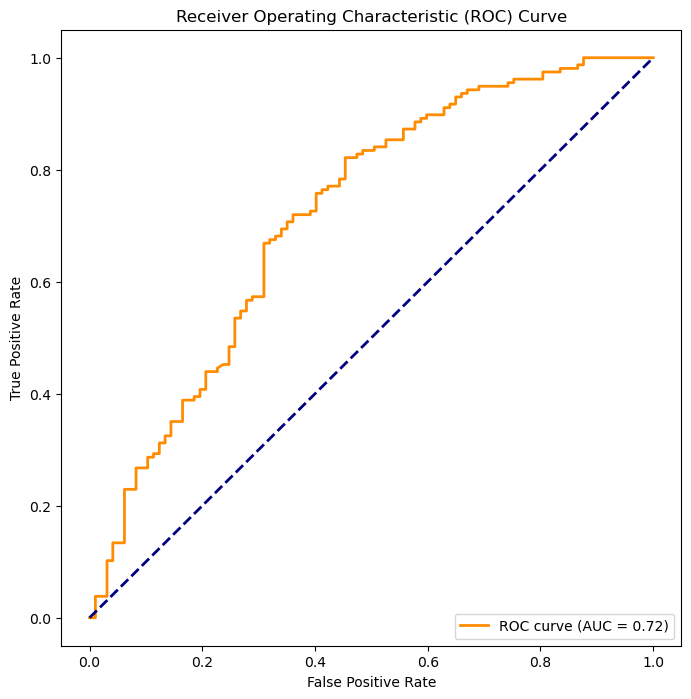

In [64]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
y_scores = predictions[0]
y_scores = torch.tensor(y_scores)
y_scores = F.softmax(y_scores, dim=1).numpy()
y_scores = y_scores[:, 1]
y_true = predictions[1]

# Assuming y_true contains true labels (0 or 1) and y_scores contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Solvability Classifier

In [65]:
df = pd.read_csv('data/solvability.csv')
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/solvability.csv')
df

,label,text
0,1,Question: A candy store has 45000 pieces of ca...
1,1,Question: The 12:05 p.m. train from New York t...
2,1,Question: Taylor Swift is on a 2-year contract...
3,1,Question: The Beverly Hills Bakery baked 200 l...
4,0,Question: There are 4 Ninja Turtles. 3 of them...
...,...,...
2535,1,Question: The volleyball team has 12 players. ...
2536,1,Question: Captain America is a superhero. He c...
2537,1,Question: 11111 is a 5-digit number. 22222 is ...
2538,1,Question: The T-Rex is 30 feet long. The Veloc...


In [124]:
df = pd.read_csv('data/solvability.csv')
df['label'] = df['label'].astype('int')
pos = df[df['label']==1]
neg = df[df['label']==0]
neg_len = len(neg)
pos = pos.sample(n = neg_len, replace = False)
df2 = pd.concat([pos, neg])
df2 = df2.sample(frac=1)
df2.reset_index(drop=True, inplace=True)
df2 = df2[df2['text'].notnull()]
df2.to_csv('data/solvability_balanced.csv')
df2

,Unnamed: 0,label,text
0,2190,0,Question: Captain America has 120 throwing sta...
1,17,1,"Question: Harry, Ron, and Hermione are in the ..."
2,694,1,"Question: Captain Marvel, a.k.a. Carol Danvers..."
3,1758,0,"Question: Steph Curry, the 2-time MVP, has 100..."
4,2533,1,"Question: In a bakery, the baker bakes 200 bun..."
...,...,...,...
771,2442,1,Question: The 10-member cheerleading squad is ...
772,393,0,Question: 1000 players are in a Fortnite match...
773,2272,1,"Question: In the first Harry Potter book, ther..."
774,1029,1,"Question: The 4 Ninja Turtles, Leonardo, Donat..."


In [66]:
# Load the dataset
#dataset = load_dataset('csv', data_files="data/solvability_balanced.csv")
dataset = load_dataset('csv', data_files="data/solvability.csv")

# Get the total number of examples in the dataset
# total_examples = len(dataset['train'])

# # Calculate the sizes of the training, test, and validation sets
# train_size = int(0.8 * total_examples)
# test_size = int(0.1 * total_examples)
# valid_size = total_examples - train_size - test_size

# # Manually split the dataset into training, test, and validation sets
# train_dataset = dataset['train'].shuffle(seed=42).select(range(train_size))
# test_dataset = dataset['train'].shuffle(seed=42).select(range(train_size, train_size + test_size))
# valid_dataset = dataset['train'].shuffle(seed=42).select(range(train_size + test_size, total_examples))

dataset_train_valid_test = dataset['train'].train_test_split(test_size = .2, seed = 42)
dataset_valid_test = dataset_train_valid_test['test'].train_test_split(test_size = .5, seed = 42)
# Create a DatasetDict to hold the splits
train_test_valid_dataset = DatasetDict({
    'train': dataset_train_valid_test['train'],
    'test': dataset_valid_test['train'],
    'valid': dataset_valid_test['test']
})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [67]:
#Set up tokenizer
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_auth_token=True)
# tokenizer.add_special_tokens({"pad_token":"[PAD]"})

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer.add_special_tokens({"pad_token":"[PAD]"})

#Preprocess and collate data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_test_valid_dataset = train_test_valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2032 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

In [68]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Prepare evaluation function
import evaluate
accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# roc_auc = evaluate.load("roc_auc")

# import numpy as np
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return roc_auc.compute(prediction_scores=predictions, references=labels)

#Training
id2label = {0: "NOT SOLVABLE", 1: "SOLVABLE"}
label2id = {"NOT SOLVABLE": 0, "SOLVABLE": 1}

In [69]:
#Import model
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained(
#     "meta-llama/Llama-2-7b-hf", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#       device_map = 'auto',
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

# model = AutoModelForSequenceClassification.from_pretrained(
#     "bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
training_args = TrainingArguments(
    output_dir="solvability_classifier",
    learning_rate=.0001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True)

trainer = BertTrainer(penalty_factor = 2,
    model=model,
    args=training_args,
    train_dataset=tokenized_train_test_valid_dataset["train"],
    eval_dataset=tokenized_train_test_valid_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
# for param in model.bert.parameters():
#     param.requires_grad = False
#trainer.train(resume_from_checkpoint=True)
trainer.train()
print(tokenized_train_test_valid_dataset["test"])
test_input_data = tokenized_train_test_valid_dataset["test"]["input_ids"]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,5.181607,0.850394
2,No log,4.534317,0.830709
3,No log,4.234334,0.846457
4,3.421200,3.841571,0.842520
5,3.421200,3.949003,0.846457
6,3.421200,3.982737,0.818898
7,3.421200,3.540523,0.822835
8,1.650600,3.558686,0.814961


Dataset({
    features: ['Unnamed: 0', 'label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 254
})


In [72]:
# predictions = trainer.predict(test_dataset=test_input_data)
# print(predictions)
trainer.evaluate(eval_dataset = tokenized_train_test_valid_dataset["test"])

{'eval_loss': 5.417053699493408,
 'eval_accuracy': 0.7716535433070866,
 'eval_runtime': 1.4922,
 'eval_samples_per_second': 170.224,
 'eval_steps_per_second': 10.723,
 'epoch': 8.0}

In [73]:
predictions = trainer.predict(test_dataset = tokenized_train_test_valid_dataset["test"])
predictions

PredictionOutput(predictions=array([[-1.7506385 ,  1.9530482 ],
       [-1.7559576 ,  1.9583346 ],
       [-1.7569892 ,  1.9590534 ],
       [-1.6437199 ,  1.8991454 ],
       [-1.749848  ,  1.9525183 ],
       [-1.7451775 ,  1.9485879 ],
       [-1.7546875 ,  1.9569901 ],
       [-1.7449911 ,  1.9491961 ],
       [-1.7599704 ,  1.9616282 ],
       [-1.7516701 ,  1.9544418 ],
       [ 0.869157  , -0.52046114],
       [-1.4514397 ,  1.773412  ],
       [ 1.0098922 , -1.2016286 ],
       [-0.42847487,  0.85188997],
       [-1.7487719 ,  1.951416  ],
       [-1.7403096 ,  1.946515  ],
       [-0.2333818 ,  0.65094006],
       [-1.7496686 ,  1.9521809 ],
       [-1.7581851 ,  1.9603089 ],
       [-1.7592822 ,  1.9612159 ],
       [-1.6754192 ,  1.9176384 ],
       [-1.7195486 ,  1.9400905 ],
       [-1.7515746 ,  1.954021  ],
       [-1.7440603 ,  1.9480331 ],
       [-1.4638046 ,  1.7823226 ],
       [-1.7575749 ,  1.9598641 ],
       [-1.7587559 ,  1.9605073 ],
       [-1.5994664 ,  1.87

In [74]:
compute_fp_tp(predictions)

(0.7037037037037037, 0.9)

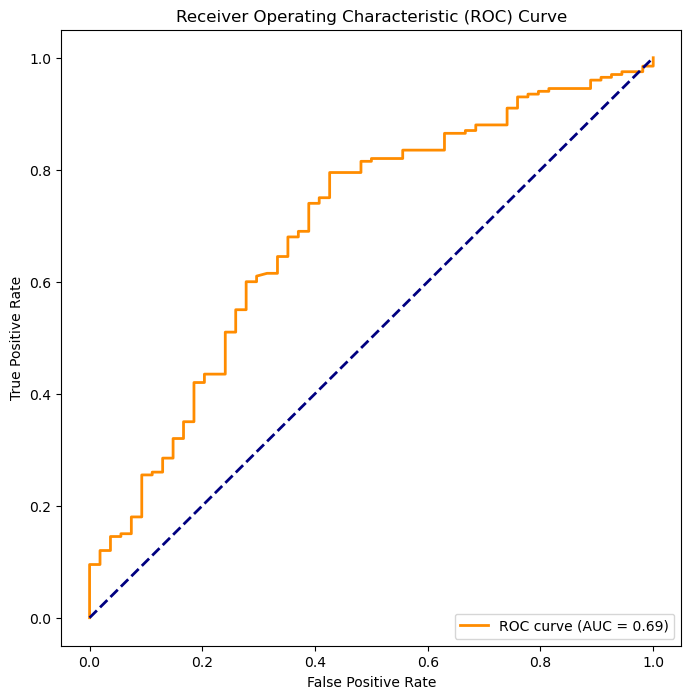

In [132]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
y_scores = predictions[0]
y_scores = torch.tensor(y_scores)
y_scores = F.softmax(y_scores, dim=1).numpy()
y_scores = y_scores[:, 1]
y_true = predictions[1]

# Assuming y_true contains true labels (0 or 1) and y_scores contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Accuracy Classifier

In [142]:
df = pd.read_csv('data/accuracy.csv')
df['label'] = df['label'].astype('int')
df.to_csv('data/accuracy.csv')

In [133]:
df = pd.read_csv('data/accuracy.csv')
df['label'] = df['label'].astype('int')
pos = df[df['label']==1]
neg = df[df['label']==0]
neg_len = len(neg)
pos = pos.sample(n = neg_len, replace = False)
df2 = pd.concat([pos, neg])
df2 = df2.sample(frac=1)
df2.reset_index(drop=True, inplace=True)
df2 = df2[df2['text'].notnull()]
df2.to_csv('data/accuracy_balanced.csv')
df2

,Unnamed: 0,label,text
0,1205,0,"Question: LeBron James, the famous NBA player,..."
1,1112,0,Question: A cheerleading squad of 100 girls is...
2,2533,0,"Question: In a bakery, the baker bakes 200 bun..."
3,979,1,Question: Iron Man has 30000 nano-bots. 10000 ...
4,2328,0,Question: Black Panther is a superhero who can...
...,...,...,...
595,514,0,Question: 3248 is the same as 32.48 when it is...
596,1863,0,Question: 3 unicorns ate 21 apples. 7 unicorns...
597,879,0,Question: The 2:00 PM train from Penn Station ...
598,2242,1,"Question: Cedric, the ice cream man, has 120 s..."


In [83]:
# Load the dataset
dataset = load_dataset('csv', data_files="data/accuracy.csv")
#dataset = load_dataset('csv', data_files="data/accuracy.csv")

# Get the total number of examples in the dataset
# total_examples = len(dataset['train'])

# # Calculate the sizes of the training, test, and validation sets
# train_size = int(0.8 * total_examples)
# test_size = int(0.1 * total_examples)
# valid_size = total_examples - train_size - test_size

# # Manually split the dataset into training, test, and validation sets
# train_dataset = dataset['train'].shuffle(seed=42).select(range(train_size))
# test_dataset = dataset['train'].shuffle(seed=42).select(range(train_size, train_size + test_size))
# valid_dataset = dataset['train'].shuffle(seed=42).select(range(train_size + test_size, total_examples))

dataset_train_valid_test = dataset['train'].train_test_split(test_size = .2, seed = 42)
dataset_valid_test = dataset_train_valid_test['test'].train_test_split(test_size = .5, seed = 42)
# Create a DatasetDict to hold the splits
train_test_valid_dataset = DatasetDict({
    'train': dataset_train_valid_test['train'],
    'test': dataset_valid_test['train'],
    'valid': dataset_valid_test['test']
})

In [84]:
#Set up tokenizer
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_auth_token=True)
# tokenizer.add_special_tokens({"pad_token":"[PAD]"})

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer.add_special_tokens({"pad_token":"[PAD]"})

#Preprocess and collate data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_test_valid_dataset = train_test_valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

In [85]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Prepare evaluation function
import evaluate
accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# roc_auc = evaluate.load("roc_auc")

# import numpy as np
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return roc_auc.compute(prediction_scores=predictions, references=labels)

#Training
id2label = {0: "NOT ACCURATE", 1: "ACCURATE"}
label2id = {"NOT ACCURATE": 0, "ACCURATE": 1}

In [86]:
#Import model
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained(
#     "meta-llama/Llama-2-7b-hf", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#       device_map = 'auto',
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

# model = AutoModelForSequenceClassification.from_pretrained(
#     "bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [139]:
import torch.nn as nn
num_ftrs = model.classifier.in_features
num_classes = 2
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 2048),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),         # Activation function (you can choose other activation functions too)
    nn.Dropout(0.4),               # Dropout layer with 20% probability
    nn.Linear(2048, num_classes)    # Final prediction fc layer
)

for param in model.bert.parameters():
    param.requires_grad = False
    
for param in model.classifier.parameters():
    param.requires_grad = True

AttributeError: 'DistilBertForSequenceClassification' object has no attribute 'bert'

In [87]:
training_args = TrainingArguments(
    output_dir="accuracy_classifier",
    learning_rate=.0001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True)

trainer = BertTrainer(penalty_factor = 2,
    model=model,
    args=training_args,
    train_dataset=tokenized_train_test_valid_dataset["train"],
    eval_dataset=tokenized_train_test_valid_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#trainer.train(resume_from_checkpoint=True)
trainer.train()
print(tokenized_train_test_valid_dataset["test"])
test_input_data = tokenized_train_test_valid_dataset["test"]["input_ids"]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,4.664889,0.864865
2,No log,4.001462,0.819820
3,No log,3.050168,0.878378
3,No log,4.293712,0.846154


KeyboardInterrupt: 

In [88]:
# predictions = trainer.predict(test_dataset=test_input_data)
# print(predictions)
trainer.evaluate(eval_dataset = tokenized_train_test_valid_dataset["test"])

{'eval_loss': 4.2937116622924805, 'eval_accuracy': 0.8461538461538461}

In [89]:
predictions = trainer.predict(test_dataset = tokenized_train_test_valid_dataset["test"])
predictions

PredictionOutput(predictions=array([[-1.2440203 ,  1.5223162 ],
       [-0.6233132 ,  0.7790685 ],
       [-0.96761084,  1.1784246 ],
       [-1.2625561 ,  1.5459605 ],
       [-1.2511543 ,  1.5341315 ],
       [-1.0308281 ,  1.2612792 ],
       [-1.1869366 ,  1.4450778 ],
       [-1.127009  ,  1.3716851 ],
       [-1.2523204 ,  1.5372587 ],
       [-1.1117508 ,  1.3562235 ],
       [-1.1614438 ,  1.4168123 ],
       [-1.1285315 ,  1.3772497 ],
       [ 0.5784071 , -0.9037413 ],
       [-1.2550079 ,  1.536453  ],
       [-1.2607725 ,  1.5443048 ],
       [-1.129681  ,  1.377318  ],
       [-1.2776465 ,  1.5663002 ],
       [ 0.6388945 , -0.9863629 ],
       [-1.2820437 ,  1.5772834 ],
       [-1.2830944 ,  1.5766681 ],
       [-1.1743785 ,  1.4321872 ],
       [-0.74474156,  0.907014  ],
       [-1.1579347 ,  1.4140929 ],
       [-1.1754882 ,  1.4351927 ],
       [-1.21394   ,  1.4841042 ],
       [-0.29844674,  0.33376005],
       [-1.1508745 ,  1.4043765 ],
       [-0.90883744,  1.10

In [90]:
compute_fp_tp(predictions)

(0.8181818181818182, 0.9627659574468085)

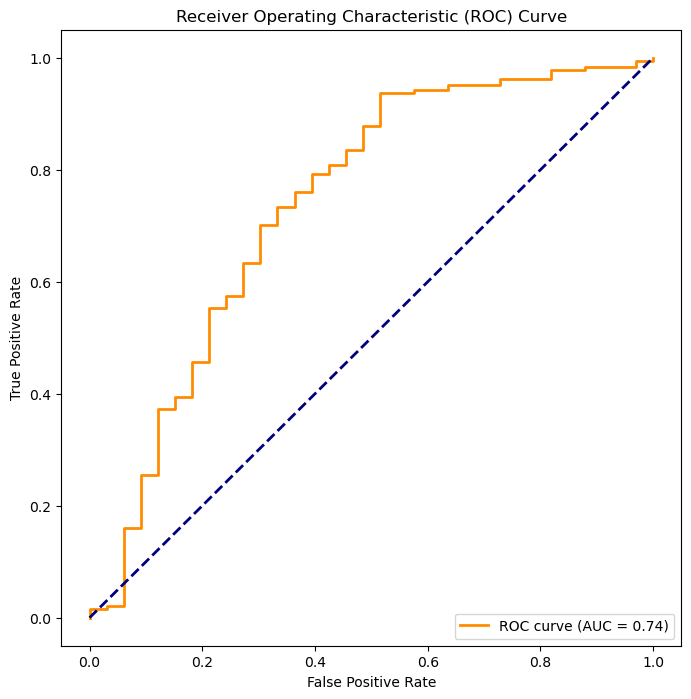

In [91]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
y_scores = predictions[0]
y_scores = torch.tensor(y_scores)
y_scores = F.softmax(y_scores, dim=1).numpy()
y_scores = y_scores[:, 1]
y_true = predictions[1]

# Assuming y_true contains true labels (0 or 1) and y_scores contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Overall Goodness Classifier

In [174]:
df = pd.read_csv('data/good.csv')
df['label'] = df['label'].astype('int')
df = df.drop('Unnamed: 0', axis =1)
df = df[df['text'].notnull()]
df.to_csv('data/good.csv')
df

,label,text
0,1,Question: A candy store has 45000 pieces of ca...
1,0,Question: The 12:05 p.m. train from New York t...
2,0,Question: Taylor Swift is on a 2-year contract...
3,1,Question: The Beverly Hills Bakery baked 200 l...
4,0,Question: There are 4 Ninja Turtles. 3 of them...
...,...,...
2536,0,Question: The volleyball team has 12 players. ...
2537,1,Question: Captain America is a superhero. He c...
2538,0,Question: 11111 is a 5-digit number. 22222 is ...
2539,1,Question: The T-Rex is 30 feet long. The Veloc...


In [175]:
# Load the dataset
dataset = load_dataset('csv', data_files="data/good.csv")

# Get the total number of examples in the dataset
# total_examples = len(dataset['train'])

# # Calculate the sizes of the training, test, and validation sets
# train_size = int(0.8 * total_examples)
# test_size = int(0.1 * total_examples)
# valid_size = total_examples - train_size - test_size

# # Manually split the dataset into training, test, and validation sets
# train_dataset = dataset['train'].shuffle(seed=42).select(range(train_size))
# test_dataset = dataset['train'].shuffle(seed=42).select(range(train_size, train_size + test_size))
# valid_dataset = dataset['train'].shuffle(seed=42).select(range(train_size + test_size, total_examples))

dataset_train_valid_test = dataset['train'].train_test_split(test_size = .2, seed = 42)
dataset_valid_test = dataset_train_valid_test['test'].train_test_split(test_size = .5, seed = 42)
# Create a DatasetDict to hold the splits
train_test_valid_dataset = DatasetDict({
    'train': dataset_train_valid_test['train'],
    'test': dataset_valid_test['train'],
    'valid': dataset_valid_test['test']
})

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [176]:
#Set up tokenizer
from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", use_auth_token=True)
# tokenizer.add_special_tokens({"pad_token":"[PAD]"})

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer.add_special_tokens({"pad_token":"[PAD]"})

#Preprocess and collate data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_test_valid_dataset = train_test_valid_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2032 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

In [177]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Prepare evaluation function
import evaluate
accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# roc_auc = evaluate.load("roc_auc")

# import numpy as np
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return roc_auc.compute(prediction_scores=predictions, references=labels)

#Training
id2label = {0: "BAD", 1: "GOOD"}
label2id = {"BAD": 0, "GOOD": 1}

In [178]:
#Import model
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained(
#     "meta-llama/Llama-2-7b-hf", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#       device_map = 'auto',
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

# model = AutoModelForSequenceClassification.from_pretrained(
#     "bert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id,
#         use_auth_token=True,  
#       # max_memory=max_memory,
#       # torch_dtype=torch.bfloat16, 
#         quantization_config=BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#             bnb_4bit_quant_type='nf4'))

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [179]:
training_args = TrainingArguments(
    output_dir="good_classifier",
    learning_rate=.0001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_test_valid_dataset["train"],
    eval_dataset=tokenized_train_test_valid_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#trainer.train(resume_from_checkpoint=True)
trainer.train()
print(tokenized_train_test_valid_dataset["test"])
test_input_data = tokenized_train_test_valid_dataset["test"]["input_ids"]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.631144,0.574803
2,No log,0.625854,0.602362
3,No log,0.582048,0.704724
4,0.548300,0.615226,0.740157
5,0.548300,0.790113,0.708661
6,0.548300,1.006566,0.696850
7,0.548300,1.183374,0.724409
8,0.185400,1.240531,0.692913


Dataset({
    features: ['Unnamed: 0', 'label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 254
})


In [180]:
predictions = trainer.predict(test_dataset = tokenized_train_test_valid_dataset["test"])
predictions

PredictionOutput(predictions=array([[-1.05403580e-01,  1.53633922e-01],
       [ 6.09290414e-02, -5.34317605e-02],
       [-4.42979664e-01,  3.64052027e-01],
       [ 7.41577387e-01, -5.98230779e-01],
       [-1.39217234e+00,  1.22615516e+00],
       [ 3.11386377e-01, -2.59676754e-01],
       [-8.81905794e-01,  7.69264221e-01],
       [ 3.58980715e-01, -2.98232138e-01],
       [-2.16182977e-01,  1.81804225e-01],
       [ 7.90851533e-01, -6.31054401e-01],
       [ 6.89657569e-01, -5.51742911e-01],
       [-1.31638515e+00,  1.14057374e+00],
       [ 7.78490365e-01, -6.26768827e-01],
       [-6.13770541e-03,  3.65272909e-02],
       [-4.17527884e-01,  3.33091706e-01],
       [ 9.64136273e-02, -5.37400506e-02],
       [ 7.72704840e-01, -6.20708764e-01],
       [-1.95953667e-01,  1.85208619e-01],
       [-1.33032691e+00,  1.12376618e+00],
       [-1.07179654e+00,  9.31076288e-01],
       [-8.86894882e-01,  7.71629632e-01],
       [-1.46392405e-01,  1.26147375e-01],
       [-1.03455544e-01, 

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
y_scores = predictions[0]
y_scores = torch.tensor(y_scores)
y_scores = F.softmax(y_scores, dim=1).numpy()
y_scores = y_scores[:, 1]
y_true = predictions[1]

# Assuming y_true contains true labels (0 or 1) and y_scores contains predicted probabilities
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Testing on IMDB Dataset

In [16]:
from datasets import load_dataset

imdb = load_dataset("imdb")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_imdb = imdb.map(preprocess_function, batched=True)
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
import evaluate

accuracy = evaluate.load("accuracy")

import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [17]:
import sys
#sys.path.append("/home/sagemaker-user/bitsandbytes")
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import bitsandbytes

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir="text_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="steps",  # Change evaluation strategy to "steps"
    eval_steps=100,  # Set the evaluation frequency to every 100 steps
    save_strategy="steps",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb['train'],
    eval_dataset=tokenized_imdb['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
100,No log,0.302497,0.876960
200,No log,0.250724,0.900440
300,No log,0.263815,0.904360


KeyboardInterrupt: 

In [6]:
conda list | grep cudatoolkit

cudatoolkit               11.8.0              h4ba93d1_12    conda-forge

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#11.8.0